In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [3]:
#Importing the data
train= pd.read_csv('Price_Train.csv')
test= pd.read_csv('Price_Test.csv')


In [4]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
train_open= train.iloc[:, 1:2].values ##taking open price from data in 2d array

In [6]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [7]:
train_open_scaled[60]

array([0.08627874])

Below we will be taking previous 60 days open datasteps to predict the next values so we are converting the data as per our input in LTSM layers. i.e for taking 0 to 59 days open price to get 60th day price as output, 1 to 60 for 61, 2 to 61 for 62

In [9]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [11]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))
xtrain.shape

(1198, 60, 1)

**Building the LSTM Model**

In [12]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout


In [13]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
40/40 [==============================] - 12s 125ms/step - loss: 0.0530
Epoch 2/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0052
Epoch 3/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0061
Epoch 4/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0053
Epoch 5/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0047
Epoch 6/100
40/40 [==============================] - 5s 125ms/step - loss: 0.0046
Epoch 7/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0044
Epoch 8/100
40/40 [==============================] - 5s 125ms/step - loss: 0.0046
Epoch 9/100
40/40 [==============================] - 5s 126ms/step - loss: 0.0042
Epoch 10/100
40/40 [==============================] - 6s 151ms/step - loss: 0.0043
Epoch 11/100
40/40 [==============================] - 5s 124ms/step - loss: 0.0041
Epoch 12/100
40/40 [==============================] - 5s 126ms/step - loss: 0.0041
Epoch 13/100

**Prediction for test data**

In [14]:
test_open= test.iloc[:, 1:2].values #taking  open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [18]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction
xtest= np.array(xtest)
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value)

**Plotting the data**

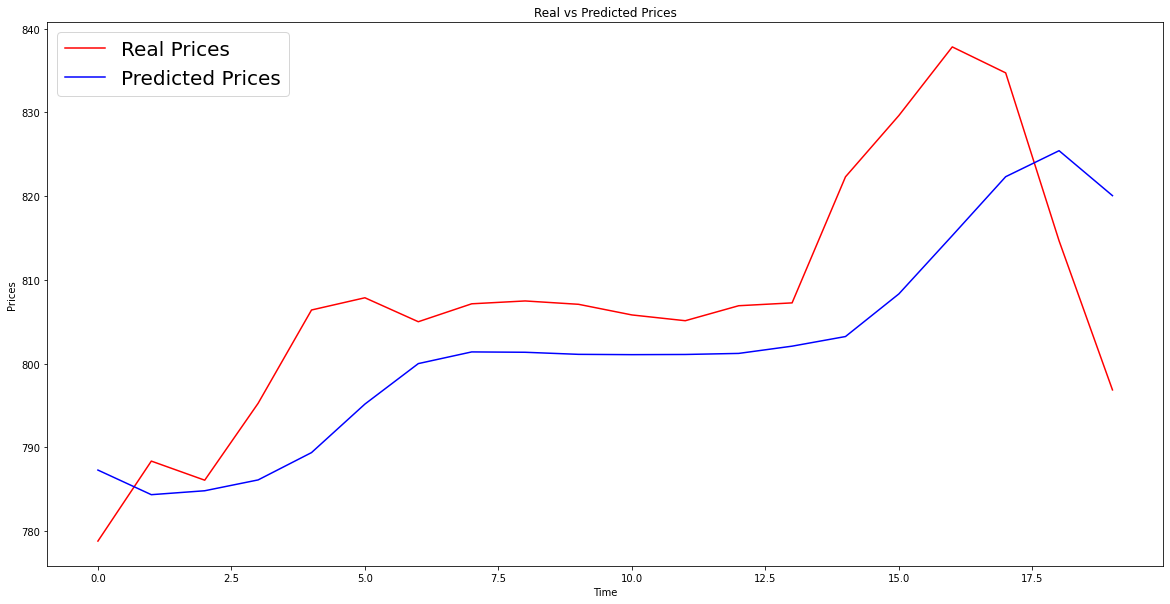

In [19]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor

In [21]:
def reg(optimizer):
    #initialisizng the model 
    regression= Sequential()

    #First Input layer and LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
    regression.add(Dropout(0.2))

    # Second LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer= 'glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Third LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
    regression.add(Dropout(0.2))
    #Output layer , we wont pass any activation as its continous value model
    regression.add(Dense(units=1))

    #Compiling the network
    regression.compile(optimizer=optimizer,loss='mean_squared_error')
    
    return regression

model= KerasRegressor(build_fn=reg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [22]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam', 'rmsprop','sgd','adadelta']}
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(xtrain, ytrain)
best_parameters = grid_search.best_params_

Epoch 1/50
30/30 [==============================] - 11s 123ms/step - loss: 0.0732
Epoch 2/50
30/30 [==============================] - 5s 159ms/step - loss: 0.0106
Epoch 3/50
30/30 [==============================] - 4s 126ms/step - loss: 0.0061
Epoch 4/50
30/30 [==============================] - 4s 123ms/step - loss: 0.0058
Epoch 5/50
30/30 [==============================] - 4s 125ms/step - loss: 0.0070
Epoch 6/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0059
Epoch 7/50
30/30 [==============================] - 4s 123ms/step - loss: 0.0060
Epoch 8/50
30/30 [==============================] - 4s 122ms/step - loss: 0.0057
Epoch 9/50
30/30 [==============================] - 4s 124ms/step - loss: 0.0054
Epoch 10/50
30/30 [==============================] - 4s 122ms/step - loss: 0.0053
Epoch 11/50
30/30 [==============================] - 4s 125ms/step - loss: 0.0052
Epoch 12/50
30/30 [==============================] - 4s 121ms/step - loss: 0.0057
Epoch 13/50
30/30 [=====

In [23]:
model=grid_search.best_estimator_.fit(xtrain,ytrain)

Epoch 1/50
24/24 [==============================] - 11s 143ms/step - loss: 0.0546
Epoch 2/50
24/24 [==============================] - 3s 142ms/step - loss: 0.0099
Epoch 3/50
24/24 [==============================] - 3s 143ms/step - loss: 0.0058
Epoch 4/50
24/24 [==============================] - 3s 145ms/step - loss: 0.0056
Epoch 5/50
24/24 [==============================] - 3s 142ms/step - loss: 0.0049
Epoch 6/50
24/24 [==============================] - 3s 142ms/step - loss: 0.0045
Epoch 7/50
24/24 [==============================] - 3s 142ms/step - loss: 0.0055
Epoch 8/50
24/24 [==============================] - 4s 186ms/step - loss: 0.0046
Epoch 9/50
24/24 [==============================] - 3s 139ms/step - loss: 0.0042
Epoch 10/50
24/24 [==============================] - 3s 141ms/step - loss: 0.0045
Epoch 11/50
24/24 [==============================] - 3s 141ms/step - loss: 0.0046
Epoch 12/50
24/24 [==============================] - 3s 142ms/step - loss: 0.0046
Epoch 13/50
24/24 [=====

In [24]:
model

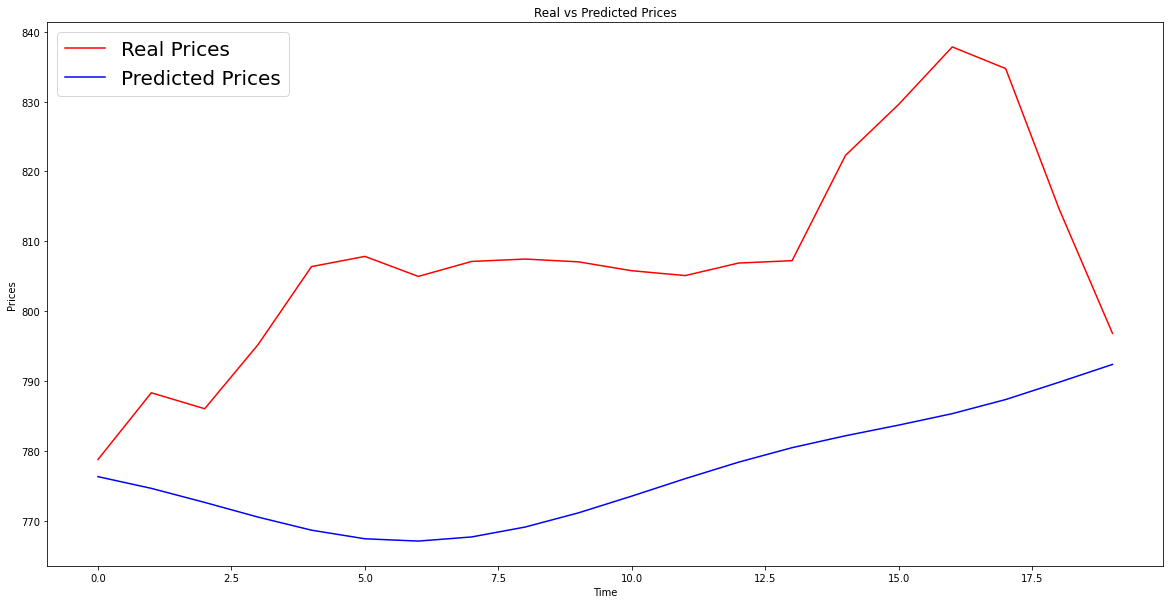

In [25]:
predicted_value= grid_search.predict(xtest)
predicted_value= ss.inverse_transform(predicted_value.reshape(-1,1))


plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)